# Table of Contents
* [Load data](#Load-data)
* [dataset validation](#dataset-validation)
* [exploring dataset](#exploring-dataset)
	* [topic names](#topic-names)
	* [question type dist](#question-type-dist)
	* [looking for missing values](#looking-for-missing-values)
* [html viz](#html-viz)
* [End](#End)


In [71]:
%%capture
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict
%load_ext autoreload
%autoreload 2

import cv2
import pprint
import pickle
import json
import requests
import io
import sys
import os
from binascii import b2a_hex
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image
from copy import deepcopy
import glob

from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.layout import LAParams, LTTextBox, LTTextLine, LTFigure, LTImage

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pdfextraction.ck12_flex_extract as ck_ex
from pdfextraction.lesson_viz import display_lesson_html

In [69]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

# Load data

__pieces from flexbooks and webbsite lessons seperated__

In [3]:
with open('ck12_flexbook_only_beta_v2.json', 'r') as f:
    flexbook_ds = json.load(f)
with open('ck12_lessons_only_beta_v2.json', 'r') as f:
    lessons_ds = json.load(f)

__combined dataset__

load or assemble from new pieces

In [4]:
# ck12_combined_dataset = {k: dict(v, **flexbook_ds[k]) for k, v in lessons_ds.items()}
with open('ck12_dataset_beta_v2.json', 'r') as f:
    ck12_combined_dataset = json.load(f)

# dataset validation

the topographic map lesson is thrown off by a missing diagram
the rest seem to be genuine unexpected_content

In [468]:
ds_assembler = ck_ex.CK12DataSetAssembler()
ds_assembler.validate_dataset(flexbook_ds)

validating schema for earth-science


Additional properties are not allowed (u'Air Pollution in the U.S.' was unexpected)
Additional properties are not allowed (u'Energy Use in the U.S.' was unexpected)
u'' is too short
u'' is too short
u'' is too short
u'' is too short
u'' is too short
u'' is too short



checking answer choice counts
earth-science 17.3 Climate Change
q03 mc error
earth-science 2.3 Topographic Maps
q14 mc error
earth-science 2.3 Topographic Maps
q09 mc error
earth-science 2.3 Topographic Maps
q11 mc error
earth-science 2.3 Topographic Maps
q10 mc error
earth-science 2.3 Topographic Maps
q13 mc error
earth-science 2.3 Topographic Maps
q12 mc error
validating schema for life-science


u'' is too short
u'' is too short
u'' is too short
u'' is too short
u'' is too short
u'' is too short
u'' is too short
u'' is too short
u'' is too short
u'' is too short



checking answer choice counts
life-science 1.5 Safety in Life Science Research
q23 mc error
life-science 21.4 Immune 

# dataset stats

## topic names

In [17]:
es_lesson_names = [item for sublist in [val['topics'].keys() for val in ck12_combined_dataset['earth-science'].values()] for item in sublist]
ps_lesson_names = [item for sublist in [val['topics'].keys() for val in ck12_combined_dataset['physical-science'].values()] for item in sublist]
ls_lesson_names = [item for sublist in [val['topics'].keys() for val in ck12_combined_dataset['life-science'].values()] for item in sublist]

combined_topics = es_lesson_names + ps_lesson_names + ls_lesson_names
topic_series = pd.Series(combined_topics).value_counts()
# topic_series[:18]
# topic_series[18:40]

In [18]:
topic_series[:20]

Summary               751
Review                748
References            703
Explore More          483
Lesson Summary        250
Lesson Objectives     248
Points to Consider    246
Introduction          246
Recall                245
Think Critically      243
Apply Concepts        243
Resources             221
Lesson Vocabulary     151
Vocabulary            101
Explore More II        94
Explore More I         93
Explore More III       17
Photosynthesis          6
Climate                 6
Proteins                5
dtype: int64

In [19]:
len(combined_topics)

9897

In [15]:
len(topic_series)

4074

__earth science topics__

In [5]:
sorted(ck12_combined_dataset['earth-science'].keys())

[u'1.1 The Nature of Science',
 u'1.2 Earth Science and Its Branches',
 u'10.1 Erosion and Deposition by Flowing Water',
 u'10.2 Erosion and Deposition by Waves',
 u'10.3 Erosion and Deposition by Wind',
 u'10.4 Erosion and Deposition by Glaciers',
 u'10.5 Erosion and Deposition by Gravity',
 u'11.1 Fossils',
 u'11.2 Relative Ages of Rocks',
 u'11.3 Absolute Ages of Rocks',
 u'12.1 The Origin of Earth',
 u'12.2 Early Earth',
 u'12.3 History of Earths Life Forms',
 u'13.1 Water on Earth',
 u'13.2 Surface Water',
 u'13.3 Groundwater',
 u'14.1 Introduction to the Oceans',
 u'14.2 Ocean Movements',
 u'14.3 The Ocean Floor',
 u'14.4 Ocean Life',
 u'15.1 The Atmosphere',
 u'15.2 Energy in the Atmosphere',
 u'15.3 Layers of the Atmosphere',
 u'15.4 Air Movement',
 u'16.1 Weather and Water in the Atmosphere',
 u'16.2 Changing Weather',
 u'16.3 Storms',
 u'16.4 Weather Forecasting',
 u'17.1 Climate and Its Causes',
 u'17.2 World Climates',
 u'17.3 Climate Change',
 u'18.1 Ecosystems',
 u'18.2 C

__life science topics__

In [27]:
sorted(ck12_combined_dataset['life-science'].keys())

[u'1.1 Scientific Ways of Thinking',
 u'1.2 What Is Life Science',
 u'1.3 The Scientific Method',
 u'1.4 The Microscope',
 u'1.5 Safety in Life Science Research',
 u'10.1 Introduction to Plants',
 u'10.2 Evolution and Classification of Plants',
 u'10.3 Plant Responses and Special Adaptations',
 u'11.1 What Are Animals',
 u'11.2 How Animals Evolved',
 u'12.1 Sponges and Cnidarians',
 u'12.2 Flatworms and Roundworms',
 u'12.3 Mollusks and Annelids',
 u'12.4 Insects and Other Arthropods',
 u'12.5 Echinoderms and Invertebrate Chordates',
 u'13.1 Introduction to Vertebrates',
 u'13.2 Fish',
 u'13.3 Amphibians',
 u'13.4 Reptiles',
 u'14.1 Birds',
 u'14.2 Mammals',
 u'14.3 Primates',
 u'15.1 Understanding Animal Behavior',
 u'15.2 Types of Animal Behavior',
 u'16.1 Introduction to the Human Body',
 u'16.2 The Integumentary System',
 u'16.3 The Skeletal System',
 u'16.4 The Muscular System',
 u'17.1 Food and Nutrients',
 u'17.2 Choosing Healthy Foods',
 u'17.3 The Digestive System',
 u'18.1 Ov

__physical science topics__

In [26]:
sorted(ck12_combined_dataset['physical-science'].keys())

[u'1.1 What Is Science',
 u'1.2 The Scope of Physical Science',
 u'10.1 Introduction to Solutions',
 u'10.2 Solubility and Concentration',
 u'10.3 Acids and Bases',
 u'11.1 Radioactivity',
 u'11.2 Radioactive Decay',
 u'11.3 Nuclear Energy',
 u'12.1 Distance and Direction',
 u'12.2 Speed and Velocity',
 u'12.3 Acceleration',
 u'13.1 What Is Force',
 u'13.2 Friction',
 u'13.3 Gravity',
 u'13.4 Elastic Force',
 u'14.1 Newtons First Law',
 u'14.2 Newtons Second Law',
 u'14.3 Newtons Third Law',
 u'15.1 Pressure of Fluids',
 u'15.2 Buoyancy of Fluids',
 u'16.1 Work',
 u'16.2 Machines',
 u'16.3 Simple Machines',
 u'16.4 Compound Machines',
 u'17.1 Types of Energy',
 u'17.2 Forms of Energy',
 u'17.3 Energy Resources',
 u'18.1 Temperature and Heat',
 u'18.2 Transfer of Thermal Energy',
 u'18.3 Using Thermal Energy',
 u'19.1 Characteristics of Waves',
 u'19.2 Measuring Waves',
 u'19.3 Wave Interactions and Interference',
 u'2.1 Scientific Investigation',
 u'2.2 Science Skills',
 u'2.3 Technolo

In [65]:
 all_lessons = ck12_combined_dataset['physical-science'].keys() + ck12_combined_dataset['life-science'].keys() + ck12_combined_dataset['physical-science'].keys() +ck12_combined_dataset['earth-science'].keys()
print len(all_lessons)

1441


In [ ]:
ck12_combined_dataset.values()

In [64]:
topic_list = [subject[lesson]['topics'].keys() for subject in ck12_combined_dataset.values() for lesson in subject]
flattened_topics = [topic for lesson in topic_list for topic in lesson]
len(flattened_topics)

9897

In [63]:
len(set(flattened_topics))

4074

## question type dist

In [7]:
q_types = []
for subject, flexbook in ck12_combined_dataset.items():
    for lesson in flexbook.values():
        for question in lesson['questions']['nonDiagramQuestions'].values():
            q_types.append(question['type'])
question_counts = pd.Series(q_types).value_counts()
print 'total number of questions = ' + str(question_counts.sum())
question_counts

total number of questions = 15616


Multiple Choice      5489
True or False        4288
Fill in the Blank    2532
Matching             1711
Short Answer         1596
dtype: int64

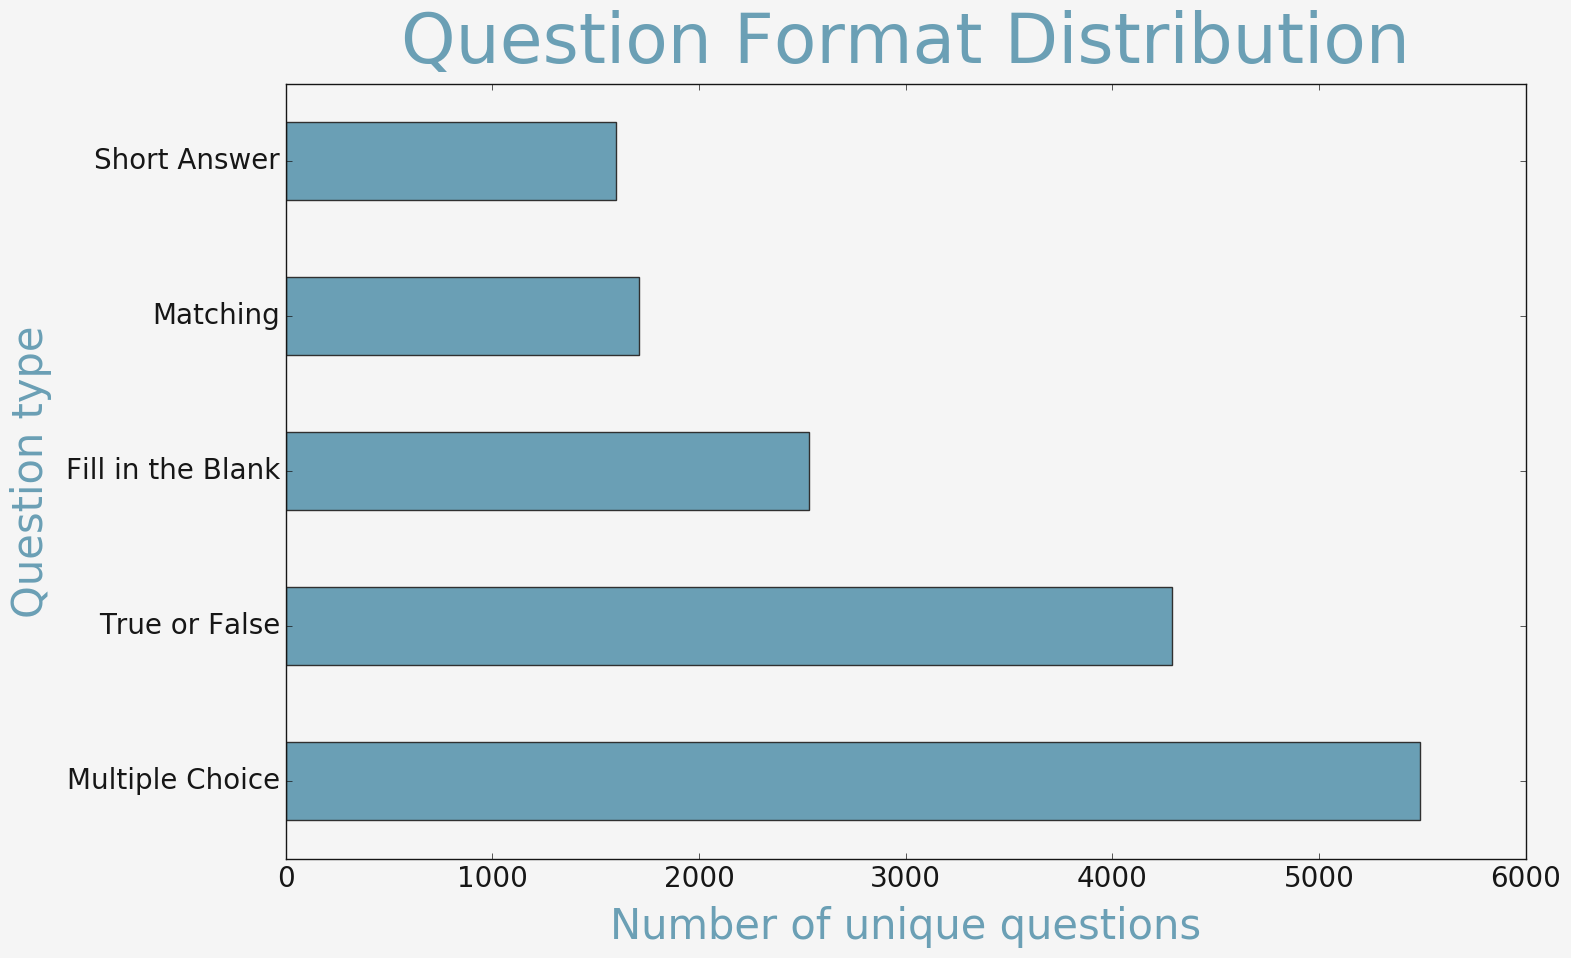

In [20]:
_ = question_counts.plot(kind="barh")
plt.title('Question Format Distribution', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Question type", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Number of unique questions", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [499]:
usable_questions = question_counts[:2].append(question_counts[3:4])

In [504]:
print 'questions usable immedeatly = ' + str(usable_questions.sum())
usable_questions

questions usable immedeatly = 11488


Multiple Choice    5489
True or False      4288
Matching           1711
dtype: int64

In [488]:
for subject, flexbook in ck12_combined_dataset.items():
    q_types = []
    for lesson in flexbook.values():
        for question in lesson['questions']['nonDiagramQuestions'].values():
            q_types.append(question['type'])
    question_counts = pd.Series(q_types).value_counts()
    print 'total number of ' + subject + ' questions = ' + str(question_counts.sum())
    print question_counts
    print 

total number of earth-science questions = 5373
Multiple Choice      2342
True or False        1702
Fill in the Blank     705
Matching              598
Short Answer           26
dtype: int64

total number of life-science questions = 5005
Multiple Choice      1927
True or False        1117
Short Answer          786
Fill in the Blank     601
Matching              574
dtype: int64

total number of physical-science questions = 5238
True or False        1469
Fill in the Blank    1226
Multiple Choice      1220
Short Answer          784
Matching              539
dtype: int64



## looking for missing values

In [414]:
for subject, flexbook in lessons_ds.items():
    q_len = []
    for lesson_name, lesson in flexbook.items():
        q_len.append(len(lesson['questions']['nonDiagramQuestions'].values()))
        if q_len[-1] == 7:
            print  subject, lesson_name
            pprint.pprint(lesson['questions']['nonDiagramQuestions'])
    q_lengths = pd.Series(q_len).value_counts()
    print 'total number of ' + subject + ' lessons = ' + str(q_lengths.sum())
    print q_lengths
    print 

total number of earth-science lessons = 271
10    267
9       2
12      1
11      1
dtype: int64

total number of life-science lessons = 271
10    270
9       1
dtype: int64

physical-science velocity
{u'q01': {u'answerChoices': {},
          u'beingAsked': {u'processedText': u'how fast an object is moving is its _____.',
                          u'rawText': u'1. How fast an object is moving is its _____.'},
          u'correctAnswer': {u'processedText': u'speed'},
          u'id': u'q01',
          u'idStructural': u'1.',
          u'type': u'Fill in the Blank'},
 u'q02': {u'answerChoices': {},
          u'beingAsked': {u'processedText': u'the measure of both speed and direction is _____.',
                          u'rawText': u'2. The measure of both speed and direction is _____.'},
          u'correctAnswer': {u'processedText': u'velocity'},
          u'id': u'q02',
          u'idStructural': u'2.',
          u'type': u'Fill in the Blank'},
 u'q03': {u'answerChoices': {},
        

The lessons with fewer questions seem to be genuine, i.e. those are the number of questions in the workbook

# html rendering

In [81]:
display_lesson_html(flexbook_ds[subject], '24.1 Flow of Energy')

In [79]:
flexbook_ds[subject]['23.4 Ecosystems']

{u'hidden': {u'source': u'566_CK-12-Life-Science-For-Middle-School_b_v77_dzc_s1.pdf'},
 u'questions': {u'diagramQuestions': {},
  u'nonDiagramQuestions': {u'q01': {u'answerChoices': {u'a': {u'idStructural': u'a.',
      u'processedText': u'water',
      u'rawText': u'a.water'},
     u'b': {u'idStructural': u'b.',
      u'processedText': u'niche',
      u'rawText': u'b.niche'},
     u'c': {u'idStructural': u'c.',
      u'processedText': u'competitive exclusion',
      u'rawText': u'c.competitive exclusion'},
     u'd': {u'idStructural': u'd.',
      u'processedText': u'competition',
      u'rawText': u'd.competition'},
     u'e': {u'idStructural': u'e.',
      u'processedText': u'ecosystem',
      u'rawText': u'e.ecosystem'},
     u'f': {u'idStructural': u'f.',
      u'processedText': u'habitat',
      u'rawText': u'f.habitat'},
     u'g': {u'idStructural': u'g.',
      u'processedText': u'sunlight',
      u'rawText': u'g.sunlight'}},
    u'beingAsked': {u'processedText': u'__common foc

In [73]:
subject = 'life-science' 
# lesson = '15.1 Understanding Animal Behavior'
random_lesson = np.random.choice(flexbook_ds[subject].keys(), 1)[0]
display_lesson_html(flexbook_ds[subject], random_lesson)

# End

In [24]:
import jinja2
from IPython.core.display import HTML

jnjenv = jinja2.Environment()

%%writefile lesson_viz.py
def make_lesson_data(lesson_json):
    nested_text = []    
    for topic, content in sorted(lesson_json['topics'].items(), key=lambda (k,v): v['orderID']):
        nested_text.append((topic, content['content']['text']))
    return nested_text

def make_page_html(lesson_data, page_html):
    return jnjenv.from_string(page_html).render(lesson=lesson_data[0], topics=lesson_data[1])

def display_lesson_html(flexbook, lesson):
    lesson_json = flexbook[lesson]
    lesson_data = (lesson, make_lesson_data(lesson_json))
    lesson_html = make_page_html(lesson_data, page_html)
    return HTML(lesson_html)

page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
    </style>
  </head>
  <body>
    <div class="container">
      <h1>Lesson: {{lesson}}</h1>
      <ul>
        {% for topic in topics %}
        <p>
        </p>
        <h3>{{topic.0}}</h3>
        <p>{{
        topic.1
        }}</p>
        {% endfor %}
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

In [ ]:

stat_data = {'Number of Entities':stats_counter, 'Average Number per image': stats_fract}
count = 2
html = "<table>"
# add header row

html += "<tr><th>"
for k in stat_data.keys():
    html += "<th>"+k

html += "<tr><th>Entity Category"
for j in range(count):
    html += "<th>"

for k, v in stats_counter.items():
    html += "<tr><th>"+k
#     for j in range(count):
    html += "<td>" + str(v)
    html += "<td>" + "%.2f" % stats_fract[k]
html += '<tr>'
    
# for k, v in stats_fract.items():
#     html += "<tr><th>"+k
#     for j in range(count):
#         html += "<td>" + str(v)
        
html += "</table>"
HTML(html)

In [25]:
page_html = """
<html>
<head>
<title>{{ title }}</title>
</head>
<body>
Hello.
</body>
</html>
"""

In [18]:
page_template = """
<html>
 <head>
  <title>KB HIT</title>
  <meta content='text/html'/>
  <script type='text/javascript' src='https://s3.amazonaws.com/mturk-public/externalHIT_v1.js'></script>
 </head>
 <body>
    <p>We are constructing a large knowledge base (KB) about elementary science and commonsense knowledge, to help computers answer questions more reliably. We are planning to release the KB as a free, open source resource for the community when it is complete. Your work here will help us assemble this KB and contribute to this effort.</p>

    <p>Below, the computer has automatically extracted some candidate facts from text for possible inclusion in the KB. However, some are weird, false, or nonsensical. This task will help us distinguish the good facts, to include in the KB, from the bad.</p>
     <form name='mturk_form' method='post' id='mturk_form' action='https://workersandbox.mturk.com/mturk/externalSubmit'>
      <input type='hidden' value='' name='assignmentId' id='assignmentId'/>		 
      <table>
        <tr><th></th><th>Commonsense Knowledge</th></tr>
        {% for n in input_data %}
            <tr><td>{{n.sentence}}</td><td nowrap>
            <!--these break-->
            <!--<input type="hidden" name="{{n.sentence_id}}" id="assignmentId" value="ASSIGNMENT_NOT_AVAILABLE" />-->
            <!--<input type="hidden" name="assignmentId" id="assignmentId" value="ASSIGNMENT_NOT_AVAILABLE" />-->
            <!--this is in the official documentation but breaks anyway!-->
            <!--<input type='hidden' value='' name='assignmentId' id='assignmentId'/>-->
            <!--this works:-->
            <input name="{{n.sentence_id}}" type="radio" value="true-act" />EXPECTED ACTION
            <input name="{{n.sentence_id}}" type="radio" value="false-act" />RARE/FALSE ACTION
            <input name="{{n.sentence_id}}" type="radio" value="true-prop" />TRUE PROPERTY
            <input name="{{n.sentence_id}}" type="radio" value="false-prop" />RARE/FALSE PROPERTY
            <input name="{{n.sentence_id}}" type="radio" value="nonsense" />NONSENSE
            <input name="{{n.sentence_id}}" type="radio" value="unknown" />DON'T KNOW
            </td></tr>
        {% endfor %}
      </table>
      <p><input type="submit" id="submitButton" value="Submit" /></p>
   </form>
  <script language="Javascript">turkSetAssignmentID();</script>
 </body>
</html>

"""